22:27:21 - cmdstanpy - INFO - Chain [1] start processing
22:27:21 - cmdstanpy - INFO - Chain [1] done processing


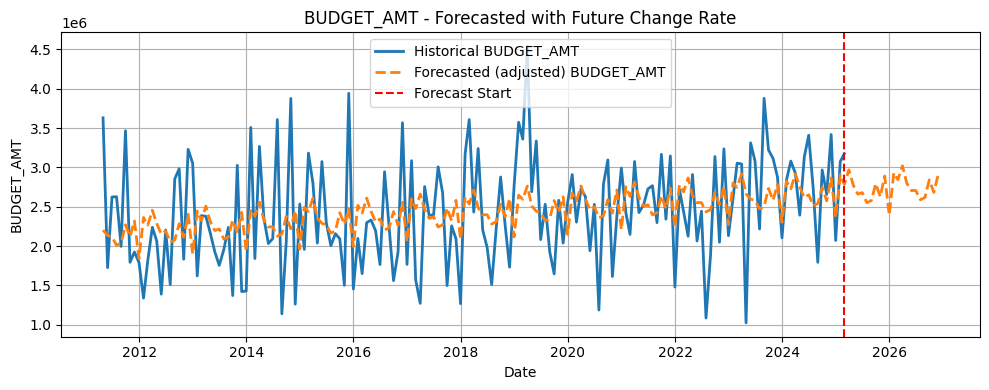

22:27:21 - cmdstanpy - INFO - Chain [1] start processing
22:27:21 - cmdstanpy - INFO - Chain [1] done processing


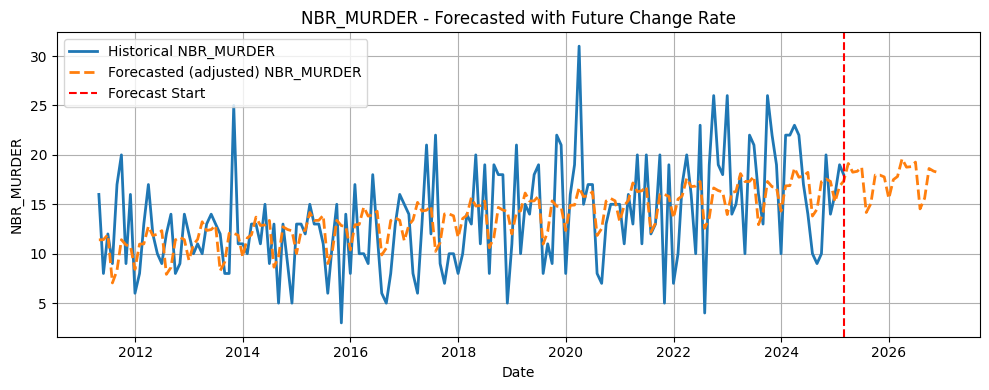

22:27:22 - cmdstanpy - INFO - Chain [1] start processing
22:27:22 - cmdstanpy - INFO - Chain [1] done processing


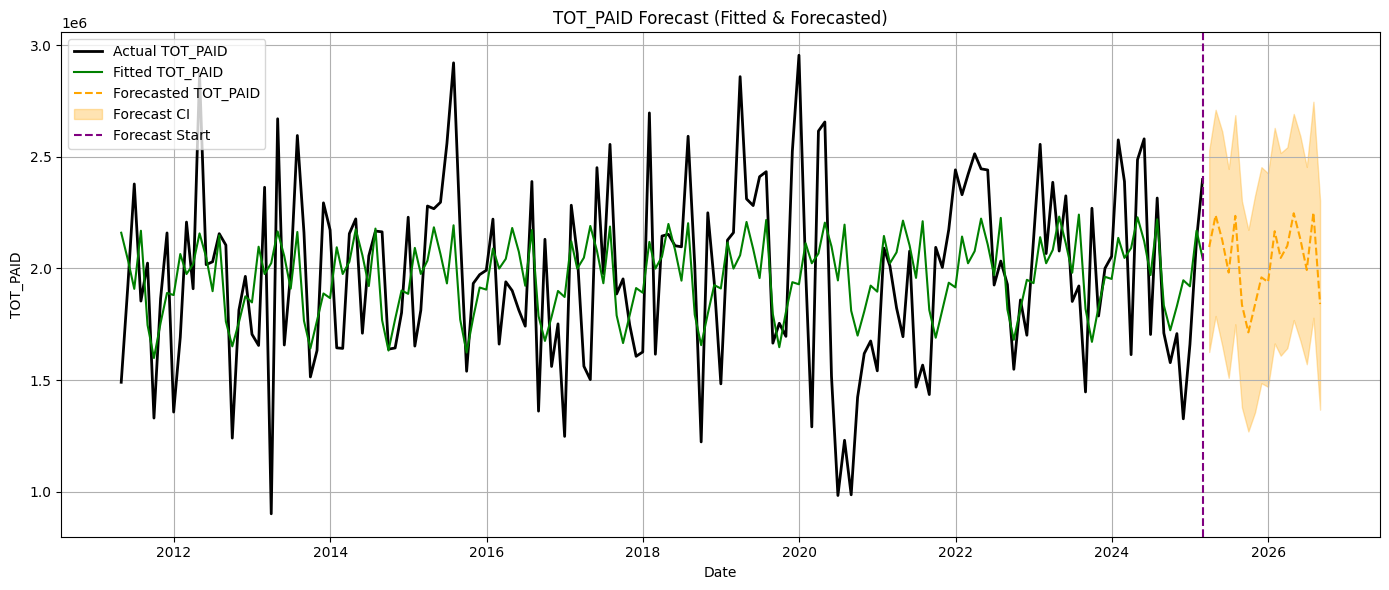


📁 Forecast saved to 'TOT_Paidforecasts.csv'

🔮 Forecasted TOT_PAID from 2025-03-31:
           ds          yhat    yhat_lower    yhat_upper
0  2025-03-31  2.096276e+06  1.625559e+06  2.530071e+06
1  2025-04-30  2.238561e+06  1.786988e+06  2.711536e+06
2  2025-05-31  2.127128e+06  1.653419e+06  2.614193e+06
3  2025-06-30  1.981839e+06  1.509691e+06  2.446445e+06
4  2025-07-31  2.235879e+06  1.750080e+06  2.687269e+06
5  2025-08-31  1.837607e+06  1.376693e+06  2.301829e+06
6  2025-09-30  1.713506e+06  1.269269e+06  2.173119e+06
7  2025-10-31  1.837874e+06  1.354547e+06  2.326281e+06
8  2025-11-30  1.960126e+06  1.485698e+06  2.454341e+06
9  2025-12-31  1.939300e+06  1.469217e+06  2.426971e+06
10 2026-01-31  2.167236e+06  1.663814e+06  2.630253e+06
11 2026-02-28  2.047271e+06  1.609152e+06  2.517551e+06
12 2026-03-31  2.101621e+06  1.642937e+06  2.543422e+06
13 2026-04-30  2.247586e+06  1.768646e+06  2.692955e+06
14 2026-05-31  2.131469e+06  1.675989e+06  2.593439e+06
15 2026-06-30  1.99

In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# === Step 1: Load data ===
file_path = "C:/GitHub/Machine-Learning/data/BCM_DATA.csv"
df = pd.read_csv(file_path, parse_dates=["ACC_MONTH"])
df = df.sort_values("ACC_MONTH")

# Prepare columns
df['ds'] = df['ACC_MONTH']
df['y'] = df['TOT_PAID']
regressors = ['BUDGET_AMT', 'NBR_MURDER']
forecast_horizon = 18


# === Step 3: Forecast each regressor normally ===
regressor_forecasts = {}

for reg in regressors:
    reg_df = df[['ds', reg]].rename(columns={reg: 'y'}).copy()

    # Fit Prophet on historical data
    reg_model = Prophet(yearly_seasonality=True)
    reg_model.fit(reg_df)

    total_needed = forecast_horizon + 3
    reg_future = reg_model.make_future_dataframe(periods=total_needed, freq='ME')
    reg_forecast = reg_model.predict(reg_future)
    reg_forecast = reg_forecast[['ds', 'yhat']].rename(columns={'yhat': reg})

    # Apply change rate only to future values
    last_date = df['ds'].max()
    forecast_start = last_date + pd.offsets.MonthEnd(1)
    future_mask = reg_forecast['ds'] >= forecast_start

    
    regressor_forecasts[reg] = reg_forecast

    # === Plot regressor trend ===
    plt.figure(figsize=(10, 4))
    plt.plot(reg_df['ds'], reg_df['y'], label=f'Historical {reg}', linewidth=2)
    plt.plot(reg_forecast['ds'], reg_forecast[reg], '--', label=f'Forecasted (adjusted) {reg}', linewidth=2)
    plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
    plt.title(f"{reg} - Forecasted with Future Change Rate")
    plt.xlabel("Date")
    plt.ylabel(reg)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Step 4: Merge full regressor forecasts ===
full_df = df[['ds', 'y']].copy()
for reg in regressors:
    full_df = full_df.merge(regressor_forecasts[reg], on='ds', how='outer')

# Fill missing and sort
full_df = full_df.sort_values('ds')
full_df[regressors] = full_df[regressors].ffill()

# === Step 5: Prepare future forecast dataframe ===
future_dates = pd.date_range(start=forecast_start, periods=forecast_horizon, freq='ME')
future_df = pd.DataFrame({'ds': future_dates})
for reg in regressors:
    future_df = future_df.merge(regressor_forecasts[reg], on='ds', how='left')
future_df = future_df.dropna(subset=regressors)

# === Step 6: Train Prophet on full historical data ===
train_df = full_df[full_df['y'].notnull()].dropna(subset=regressors).copy()
model = Prophet(yearly_seasonality=True)
for reg in regressors:
    model.add_regressor(reg)
model.fit(train_df)

# === Step 7: Make both in-sample and future predictions ===
# In-sample prediction
in_sample = model.predict(train_df[["ds"] + regressors])
in_sample['source'] = 'Fitted'

# Future prediction
forecast = model.predict(future_df)
forecast['source'] = 'Forecast'

# Combine both
combined_forecast = pd.concat([in_sample[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'source']],
                               forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'source']]])

# === Step 8: Plot final TOT_PAID forecast with fitted values ===
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['TOT_PAID'], label='Actual TOT_PAID', color='black', linewidth=2)

# Plot fitted and forecasted separately
plt.plot(in_sample['ds'], in_sample['yhat'], label='Fitted TOT_PAID', color='green')
plt.plot(forecast['ds'], forecast['yhat'], '--', label='Forecasted TOT_PAID', color='orange')

# Confidence intervals for forecast
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='orange', alpha=0.3, label='Forecast CI')

plt.axvline(x=last_date, color='purple', linestyle='--', label='Forecast Start')
plt.title("TOT_PAID Forecast (Fitted & Forecasted)")
plt.xlabel("Date")
plt.ylabel("TOT_PAID")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 8.5: Save fitted and forecasted values to CSV ===
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("C:/GitHub/Machine-Learning/data/TOT_Paidforecasts.csv", index=False)
print("\n📁 Forecast saved to 'TOT_Paidforecasts.csv'")

# === Step 9: Display final forecast ===
print(f"\n🔮 Forecasted TOT_PAID from {forecast_start.date()}:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



In [8]:
forecast.head(20)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,BUDGET_AMT,BUDGET_AMT_lower,BUDGET_AMT_upper,NBR_MURDER,...,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,source
0,2025-03-31,2.387836e+06,1.625559e+06,2.530071e+06,2.387836e+06,2.387836e+06,-228109.290968,-228109.290968,-228109.290968,-411137.126708,...,-639246.417676,-639246.417676,347686.166475,347686.166475,347686.166475,0.0,0.0,0.0,2.096276e+06,Forecast
1,2025-04-30,2.392720e+06,1.786988e+06,2.711536e+06,2.392720e+06,2.392720e+06,-144842.947722,-144842.947722,-144842.947722,-344368.405550,...,-489211.353272,-489211.353272,335051.761816,335051.761816,335051.761816,0.0,0.0,0.0,2.238561e+06,Forecast
2,2025-05-31,2.397768e+06,1.653419e+06,2.614193e+06,2.397768e+06,2.397768e+06,-96562.394820,-96562.394820,-96562.394820,-351217.318352,...,-447779.713172,-447779.713172,177139.867666,177139.867666,177139.867666,0.0,0.0,0.0,2.127128e+06,Forecast
3,2025-06-30,2.402652e+06,1.509691e+06,2.446445e+06,2.402652e+06,2.402652e+06,-104873.724182,-104873.724182,-104873.724182,-382371.880431,...,-487245.604613,-487245.604613,66431.965920,66431.965920,66431.965920,0.0,0.0,0.0,1.981839e+06,Forecast
4,2025-07-31,2.407699e+06,1.750080e+06,2.687269e+06,2.407699e+06,2.407700e+06,-50048.113817,-50048.113817,-50048.113817,-37215.462724,...,-87263.576541,-87263.576541,-84557.156123,-84557.156123,-84557.156123,0.0,0.0,0.0,2.235879e+06,Forecast
5,2025-08-31,2.412747e+06,1.376693e+06,2.301829e+06,2.412747e+06,2.412747e+06,-61759.592629,-61759.592629,-61759.592629,-103891.765519,...,-165651.358148,-165651.358148,-409488.596835,-409488.596835,-409488.596835,0.0,0.0,0.0,1.837607e+06,Forecast
6,2025-09-30,2.417631e+06,1.269269e+06,2.173119e+06,2.417631e+06,2.417631e+06,-153145.253524,-153145.253524,-153145.253524,-322742.684813,...,-475887.938337,-475887.938337,-228237.460097,-228237.460097,-228237.460097,0.0,0.0,0.0,1.713506e+06,Forecast
7,2025-10-31,2.422679e+06,1.354547e+06,2.326281e+06,2.422678e+06,2.422679e+06,-83072.534794,-83072.534794,-83072.534794,-322544.866461,...,-405617.401255,-405617.401255,-179187.620608,-179187.620608,-179187.620608,0.0,0.0,0.0,1.837874e+06,Forecast
8,2025-11-30,2.427563e+06,1.485698e+06,2.454341e+06,2.427563e+06,2.427563e+06,-194400.258837,-194400.258837,-194400.258837,-308167.693442,...,-502567.952279,-502567.952279,35130.408537,35130.408537,35130.408537,0.0,0.0,0.0,1.960126e+06,Forecast
9,2025-12-31,2.432610e+06,1.469217e+06,2.426971e+06,2.432610e+06,2.432611e+06,16858.070478,16858.070478,16858.070478,-143528.009524,...,-126669.939046,-126669.939046,-366640.010632,-366640.010632,-366640.010632,0.0,0.0,0.0,1.939300e+06,Forecast


In [9]:
df.head()

,ACC_MONTH,FISCAL_YEAR,ACCOUNTING_PERIOD,TOT_PAID,BUDGET_AMT,NBR_CASE,NBR_MURDER,NBR_OTHER,ds,y
0,2011-04-30,2011,1,1489878.86,3629805.06,62,16,46,2011-04-30,1489878.86
1,2011-05-31,2011,2,1922713.79,1724956.61,41,8,33,2011-05-31,1922713.79
2,2011-06-30,2011,3,2378873.09,2623665.50,38,12,26,2011-06-30,2378873.09
3,2011-07-31,2011,4,1853901.62,2626410.66,49,9,40,2011-07-31,1853901.62
4,2011-08-31,2011,5,2024100.54,1995629.23,33,17,16,2011-08-31,2024100.54


In [3]:
df.head()

,ACC_MONTH,FISCAL_YEAR,ACCOUNTING_PERIOD,TOT_PAID,BUDGET_AMT,NBR_CASE,NBR_MURDER,NBR_OTHER,ds,y
0,2011-04-30,2011,1,1489878.86,3629805.06,62,16,46,2011-04-30,1489878.86
1,2011-05-31,2011,2,1922713.79,1724956.61,41,8,33,2011-05-31,1922713.79
2,2011-06-30,2011,3,2378873.09,2623665.50,38,12,26,2011-06-30,2378873.09
3,2011-07-31,2011,4,1853901.62,2626410.66,49,9,40,2011-07-31,1853901.62
4,2011-08-31,2011,5,2024100.54,1995629.23,33,17,16,2011-08-31,2024100.54


In [4]:
df[['TOT_PAID', 'BUDGET_AMT', 'NBR_CASE','NBR_MURDER','NBR_OTHER']].corr()

,TOT_PAID,BUDGET_AMT,NBR_CASE,NBR_MURDER,NBR_OTHER
TOT_PAID,1.000000,0.040651,0.137807,0.093982,0.121304
BUDGET_AMT,0.040651,1.000000,0.665593,0.424706,0.600371
NBR_CASE,0.137807,0.665593,1.000000,0.604419,0.918700
NBR_MURDER,0.093982,0.424706,0.604419,1.000000,0.240632
NBR_OTHER,0.121304,0.600371,0.918700,0.240632,1.000000


In [ ]:

import pandas as pd

# Load the CSV files
bcm_data = pd.read_csv("C:/GitHub/Machine-Learning/data/BCM_DATA.csv")
forecast_data = pd.read_csv("C:/GitHub/Machine-Learning/data/TOT_Paidforecasts.csv")

# Convert date columns to datetime
bcm_data['ACC_MONTH'] = pd.to_datetime(bcm_data['ACC_MONTH'])
forecast_data['ds'] = pd.to_datetime(forecast_data['ds'])

# Merge the two datasets on the date columns using a full outer join
merged_data = pd.merge(
    bcm_data,
    forecast_data,
    left_on='ACC_MONTH',
    right_on='ds',
    how='outer'
)

# Optional: Drop duplicate date columns if desired
merged_data.drop(columns=['ds'], inplace=True)

# Save or display the merged dataframe
merged_data.to_csv("C:/GitHub/Machine-Learning/data/merged_full_data.csv", index=False)
print(merged_data.head())


   ACC_MONTH  FISCAL_YEAR  ACCOUNTING_PERIOD    TOT_PAID  BUDGET_AMT  \
0 2011-04-30       2011.0                1.0  1489878.86  3629805.06   
1 2011-05-31       2011.0                2.0  1922713.79  1724956.61   
2 2011-06-30       2011.0                3.0  2378873.09  2623665.50   
3 2011-07-31       2011.0                4.0  1853901.62  2626410.66   
4 2011-08-31       2011.0                5.0  2024100.54  1995629.23   

   NBR_CASE  NBR_MURDER  NBR_OTHER  yhat  yhat_lower  yhat_upper  
0      62.0        16.0       46.0   NaN         NaN         NaN  
1      41.0         8.0       33.0   NaN         NaN         NaN  
2      38.0        12.0       26.0   NaN         NaN         NaN  
3      49.0         9.0       40.0   NaN         NaN         NaN  
4      33.0        17.0       16.0   NaN         NaN         NaN  


In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# === Step 7.5: Evaluate model accuracy using the last 20% of actuals ===
split_index = int(len(train_df) * 0.8)
train_actuals = train_df.iloc[:split_index]
test_actuals = train_df.iloc[split_index:]

# Predict on historical test data
test_forecast = model.predict(test_actuals[['ds'] + regressors])

# Extract actuals and predictions
y_true = test_actuals['y'].values
y_pred = test_forecast['yhat'].values

# === Accuracy Metrics ===
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# === Print Accuracy Results ===
print("\n📊 Forecast Accuracy on Holdout Test Set:")
print(f"🔹 RMSE : {rmse:,.2f}")
print(f"🔹 MAE  : {mae:,.2f}")
print(f"🔹 MAPE : {mape:.2f}%")


📊 Forecast Accuracy on Holdout Test Set:
🔹 RMSE : 285,711.86
🔹 MAE  : 236,277.47
🔹 MAPE : 12.05%


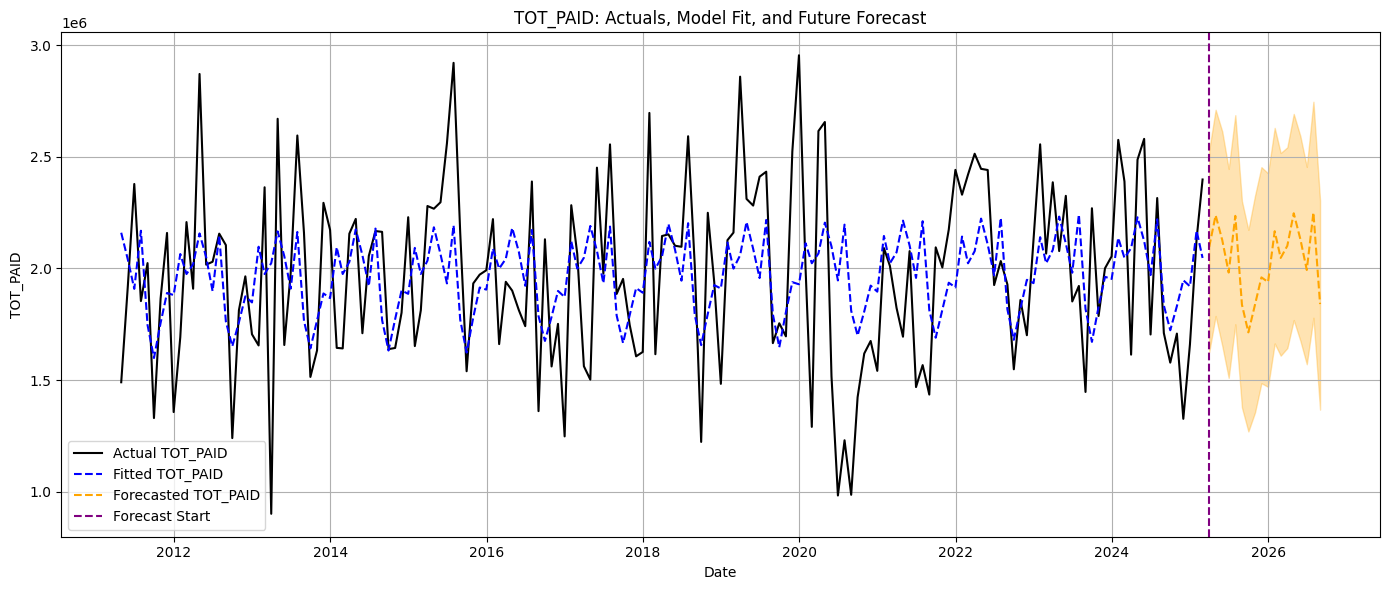

In [6]:
# === Step 8: Full Forecast Plot (Actuals + Predictions + Future Forecast) ===
# Merge predictions with actual data for full timeline visualization
full_timeline = pd.concat([
    train_df[['ds', 'y']].copy().assign(type='Actual'),
    model.predict(train_df[['ds'] + regressors])[['ds', 'yhat']].rename(columns={'yhat': 'y'}).assign(type='Predicted'),
    forecast[['ds', 'yhat']].rename(columns={'yhat': 'y'}).assign(type='Forecast')
], ignore_index=True)

plt.figure(figsize=(14, 6))

# Plot Actuals
actuals = full_timeline[full_timeline['type'] == 'Actual']
plt.plot(actuals['ds'], actuals['y'], label='Actual TOT_PAID', color='black')

# Plot Model Fit
predicted = full_timeline[full_timeline['type'] == 'Predicted']
plt.plot(predicted['ds'], predicted['y'], label='Fitted TOT_PAID', color='blue', linestyle='--')

# Plot Forecast
forecasted = full_timeline[full_timeline['type'] == 'Forecast']
plt.plot(forecasted['ds'], forecasted['y'], label='Forecasted TOT_PAID', color='orange', linestyle='--')

# Add forecast confidence interval
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)

# Mark forecast start
plt.axvline(x=forecast_start, color='purple', linestyle='--', label='Forecast Start')

plt.title("TOT_PAID: Actuals, Model Fit, and Future Forecast")
plt.xlabel("Date")
plt.ylabel("TOT_PAID")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()